# Projeto: Determinação do Risco de Doença Cardiovascular



## Utilização de classificadores para indicar o risco de morte por doença cardiovascular com base em fatores de alto risco.


### Importação dos módulos utilizados nesse projeto:

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
import sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler 

from imblearn.over_sampling import SMOTENC

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from scipy import stats
from sklearn.model_selection import KFold

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score, plot_roc_curve
from sklearn.metrics import f1_score
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm 

### Dataset encontrado na plataforma Kaggle:
https://www.kaggle.com/andrewmvd/heart-failure-clinical-data

## Leitura dos dados 

In [2]:
df = pd.read_csv('heart_failure_clinical_records_dataset.csv')
df.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1


## Análise da correlação entre as variáveis da base de dados

<AxesSubplot:>

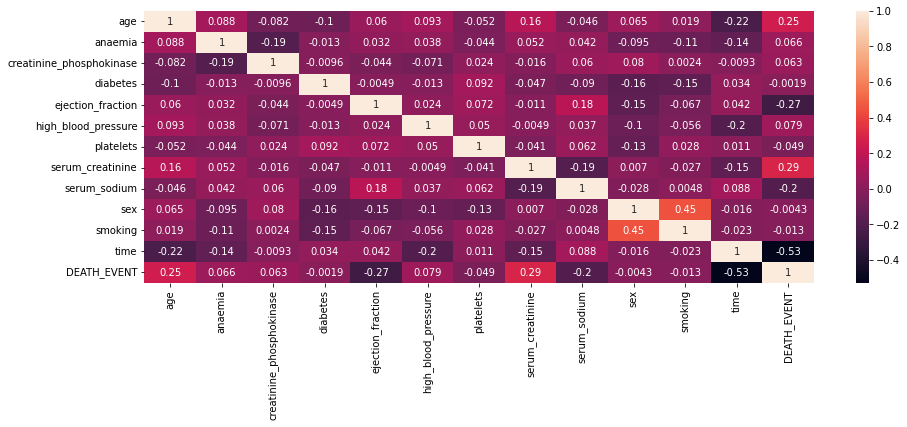

In [3]:
plt.figure(figsize=(15,5))
sns.heatmap(df.corr(), annot=True)

As colunas "diabetes" e "sex" apresentam baixa correlação com morte por doenças do coração (DEATH_EVENT). Além disso, "sex" e "smoking" apresentam uma alta correlação entre elas. Dessa forma, as características "diabetes" e "sex" foram removidas do dataframe visando a melhoria do modelo.

## Limpeza e balanceamento dos dados

Para melhorar a qualidade dos dados, será realizada uma análise sobre os dados para observar a existêcia de valores nulos, valores vazios ou de amostras duplicadas.

In [4]:
df.isnull().head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,False,False,False,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,False,False,False


<AxesSubplot:>

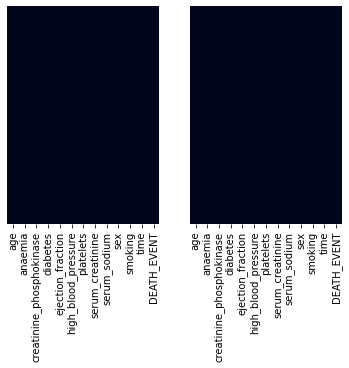

In [5]:
fig, (ax1, ax2) = plt.subplots(1, 2)
sns.heatmap(df.isnull(),cbar=False,yticklabels=False, ax=ax1)

sns.heatmap(df.isna(),cbar=False,yticklabels=False, ax=ax2)

In [6]:
print("Total de amostras antes da limpeza:", len(df))

df.drop_duplicates(inplace=True)
df.dropna(axis=0, how ='any')

print("Total de amostras após a limpeza:", len(df)) 

Total de amostras antes da limpeza: 299
Total de amostras após a limpeza: 299


É possível perceber que foram realizados alguns procedimentos par a limpeza dos dados, porém os dados não apresentaram dados nulos ou dados duplicados.

## Normalização dos dados do dataset

Considerando que existem dados com escala muito diferente, o que pode enviesar o processo de classificação, e que existem algumas variáveis categóricas, com valores 0 ou 1, foi realizada a aplicação de um método para normalizar os dados.

Foi considerado o método Min-max para normalizar os dados para a escala de \[0  1\].


In [7]:
x = df.iloc[:, 0:12].copy()
y = df['DEATH_EVENT'].copy()

scaler = MinMaxScaler()

x[['age', 'creatinine_phosphokinase', 'ejection_fraction', 'platelets', 'serum_creatinine', 'serum_sodium', 'time']] = scaler.fit_transform(x[['age', 'creatinine_phosphokinase', 'ejection_fraction', 'platelets', 'serum_creatinine', 'serum_sodium', 'time']])
x.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time
0,0.636364,0,0.071319,0,0.090909,1,0.290823,0.157303,0.485714,1,0,0.000000
1,0.272727,0,1.000000,0,0.363636,0,0.288833,0.067416,0.657143,1,0,0.007117
2,0.454545,0,0.015693,0,0.090909,0,0.165960,0.089888,0.457143,1,1,0.010676
3,0.181818,1,0.011227,0,0.090909,0,0.224148,0.157303,0.685714,1,0,0.010676
4,0.454545,1,0.017479,1,0.090909,0,0.365984,0.247191,0.085714,0,0,0.014235


Removendo as colunas "sex" e "diabetes" do dataframe, considerando a análise da correlação realizada anteriormente.

In [8]:
del x['sex']
del x['diabetes']

## Removendo outliers

Foi utilizado o cálculo do Z-Score para encontrar *outliers*. O Z-Score calcula o número de desvios padrão acima ou abaixo da média para uma amostra. Em outras palavras, é uma medida de dispersão que possibilita analisar se uma determinada amostra está muito distante da média, configurando-se como um *outlier*.

Considerando uma Gaussiana, são considerados *outliers*, amostras com desvio padrão maior ou igual a 3. Dessa forma, foram remividos as amostras que correspondem a esse valor de desvio padrão.

In [9]:
z_score = np.abs(stats.zscore(x))
location_of_outliers = np.where(z_score >= 3)
x.drop(location_of_outliers[0], inplace = True)
y.drop(location_of_outliers[0], inplace = True)

In [10]:
# Índice os dados removidos
location_of_outliers[0]

array([  1,   4,   9,  19,  28,  52,  52,  60,  64,  72, 103, 105, 109,
       131, 134, 171, 199, 217, 228, 296], dtype=int64)

## Balanceamento dos dados baseados 

Considerando que a base de dados apresenta duas classes, é possível que exista um desbalanceamento dos dados, considerando mais amostras para uma das classes.

Na base de dados utilizada nesse projeto, é possível perceber o desbalanceamento, consiedrando um maior número de amostras calasificadas com *DEATH_EVENT = 0*

In [11]:
print('Total de óbitos: ', y.sum())
print('Total de não óbitos: ', len(y) -sum(y) )

Total de óbitos:  86
Total de não óbitos:  194


Foi utilizada a biblioteca **SMOTE** para equilibrar quantidade de amostras para determinadas classes. Ela cria dados sintéticos para as características numéricas e categóricas e torna o modelo mais baanceado.

In [12]:
new_x, new_y = SMOTENC(categorical_features=[1,4,8], random_state=1, k_neighbors=3).fit_resample(x, y)

Dessa forma, é possível perceber que a base de dados se encontra balanceada:

In [13]:
print('Total de óbitos: ', new_y.sum())
print('Total de não óbitos: ', len(new_y) -sum(new_y) )

Total de óbitos:  194
Total de não óbitos:  194


## Modelagem, treino e validação do classificador

### Divisão dos dados de treino e dados de teste

Após limpos e balanceados, os dados foram divididos com a proporção de 70% das amostras para treinamento e 30% para teste. Essa é uma proporção popularmente utilizada nas bibliografias sobre classificação.

In [14]:
x_train, x_test, y_train, y_test = train_test_split(new_x, new_y, test_size = 0.3, random_state = 1, shuffle=True)

### Definição do modelo do classificador Random Forest

Foi modelado um classificador baseado no algoritmo de classificação Random Forest. Esse é um dos algoritmos mais utilizados devido a sua facilidade e desempenho na classificação.

In [15]:
random_forest = RandomForestClassifier(max_depth=12, random_state=1, criterion='gini')

### Validando o modelo com a estratégia K-fold

Para validar o modelo definido anteriormente, foi implementado uma validação utilizando a estratégia K-Fold. O K-fold valida o grupo de modelo por meio de uma sequência de iterações, aplicando um subgrupo das amostras para treinamento e outra parte para teste (80% e 20%, respectivamente). Com isso, é possível analisar a acurácia média dessas iterações.

Considerando um total de 10 *folds*, o algoritmo executou o planejamentos e testes por 10 vezes, obtendo a seguinte acurácia:

In [16]:
k=10
kf = KFold(n_splits=k, random_state=None, shuffle=False)
X_kf = x_train.copy()
y_kf = y_train.copy()
acc_score = []
for train_index, test_index in kf.split(X_kf):#80% 20%
    Xkf_train, Xkf_test = X_kf.iloc[train_index,:], X_kf.iloc[test_index,:]
    y_kf_train = y_kf.iloc[train_index]
    y_kf_test = y_kf.iloc[test_index]
    random_forest.fit(Xkf_train, y_kf_train)
    pred_values = random_forest.predict(Xkf_test)
    acc = accuracy_score(pred_values , y_kf_test)
    acc_score.append(acc)
avg_acc_score = sum(acc_score)/k

print('Acurácia de cada fold — {}'.format(acc_score))
print()
print(f'Acurácia média para k={k} : {avg_acc_score*100:.2f}%')

Acurácia de cada fold — [0.8571428571428571, 0.8148148148148148, 0.9259259259259259, 0.8888888888888888, 0.8888888888888888, 0.9259259259259259, 0.9629629629629629, 0.8888888888888888, 0.9259259259259259, 0.8888888888888888]

Acurácia média para k=10 : 89.68%


### Treinando o modelo

Considerando o modelo validado no passo anterior, o mesmo foi treinado considerando as amostras reservadas para treino.

In [17]:
random_forest.fit(x_train, y_train)

RandomForestClassifier(max_depth=12, random_state=1)

## Testes e Avaliações

### Testando o modelo

Em seguida é realizada a predição com base no modelo. Ou seja, o modelo é submetido às amostras reservada para os testes.

In [18]:
y_predicted = random_forest.predict(x_test)

### Métricas de Avaliaçao

A fim de avaliar o classificador modelado, foram consideradas algumas estratégias. Levando em consideração que se trata de uma aplicação médica, além da avaliação da acurácia, é importante avaliar se os testes apresentam muitos falsos negativos. Dessa forma, foi calculada uma matriz de confusão para avaliar a eficiência do classificador. 

Grund truth: EVENT_DEATH = TRUE 58
Grund truth: EVENT_DEATH = FALSE 59


<AxesSubplot:>

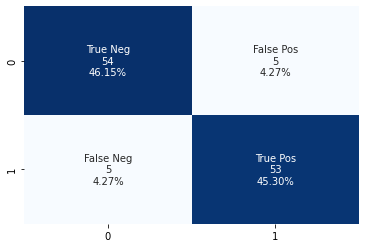

In [19]:
print('Grund truth: EVENT_DEATH = TRUE', sum(y_test)) # EVENT_DEATH = TRUE = 0
print('Grund truth: EVENT_DEATH = FALSE', len(y_test)-sum(y_test)) # EVENT_DEATH = FALSE = 1

cm = confusion_matrix(y_test, y_predicted, labels=random_forest.classes_)

group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in cm.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in cm.flatten()/np.sum(cm)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

sns.heatmap(cm, annot=labels, fmt='', cmap='Blues', cbar=False)

É possível perceber que, das 59 amostras de teste em que não ocorreu óbito, 54 foram classificadas corretamente (Verdadeiro Negativo) e 5 foram classificadas como óbito (Falso Positivo). Para as 58 amostras em que ocorreu óbito, 53 foram classificadas corretamente (Verdadeiro Positivo) e 5 classificadas incorretamente (Falso Negativo).

In [20]:
Accuracy = accuracy_score(y_test, y_predicted)
print(f"Accuracy {Accuracy*100:.2f}% ")
print(f'Recall: {recall_score(y_test, y_predicted)*100:.2f}%')
print(f'Precision: {precision_score(y_test, y_predicted)*100:.2f}%')
#print(f"Eficiency: {((0.9153+0.9138)/2)*100:.2f}%")
print(f'F1-Score: {f1_score(y_test, y_predicted)*100:.2f}%')
print()

# Obtendo as métricas por meio do classification_report
target_names = ['Death: F', 'Death: T']
print(classification_report(y_test, y_predicted, target_names=target_names, digits = 4))

#plot_roc_curve(random_forest, x_test.values, y_test) 
#plt.show()

Accuracy 91.45% 
Recall: 91.38%
Precision: 91.38%
F1-Score: 91.38%

              precision    recall  f1-score   support

    Death: F     0.9153    0.9153    0.9153        59
    Death: T     0.9138    0.9138    0.9138        58

    accuracy                         0.9145       117
   macro avg     0.9145    0.9145    0.9145       117
weighted avg     0.9145    0.9145    0.9145       117



Analisando o relatório da classificação, é possível analisar algumas métricas para a avaliação do modelo. A acurácia, medida da quantidade de acertos em relação ao total de classificações, foi de 91,45%. A métrica de precisão, que indica a habilidade do modelo em realizar predições (Verdadeiro Positivo) corretamente, foi de 91,38%.

Como o problema em questão se trata de uma classificação binária, o valor da métrica *recall* para a classe positiva (Death_Event = 1), equivale à **Sensibilidade**, enquanto o valor da métrica *recall* para a classe negativa (Death_Event = 0) equivale à **Especificidade**. 

Dessa forma, a Sensibilidade do modelo foi de 91,38%, indicando a capacidade do modelo classificar corretamente a classe de interesse (Death_Event = 1). Por outro lado, a Especificidade do modelo foi de 91,53%, indicando a capacidade do modelo em predizer corretamente a outra classe (Death_Event = 0).

Finalmente, a métrica f1-score, uma média que contempla a informação da precisão do *recall*, foi de 91.38%.


# Testando outros classificadores

De maneira mais simplificada, foram realizados alguns testes para avaliar a efetividade de outros classificadores clássicos. Foram considerados a rede neural MLP (*Multlayer Perceptron*), o classificador KNN (*K-Nearest Neighborhood*) e o classificador SVM (*Support Vector Machine*).

Esses classificadores foram aplicados pois são importantes algoritmos de classificação, que para algumas aplicações, apresentam excelente desempenho.

### MLP Classifier

Accuracy : 88.03%
Recall: 86.21%
Precision: 89.29%
f1-score: 87.72%


<AxesSubplot:>

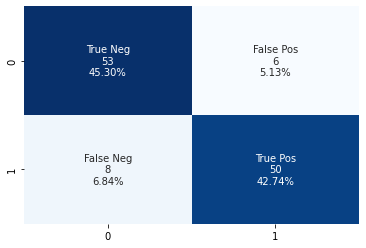

In [21]:
#Definindo o modelo
clf = MLPClassifier(random_state=1, max_iter=3000, hidden_layer_sizes=(1000,10),
                    activation='relu', solver='adam')

#Treinando o modelo
clf.fit(x_train, y_train)

#Testando o modelo
y_predicted_mlp = clf.predict(x_test)
accuracy_mlp = accuracy_score(y_test, y_predicted_mlp)

print(f"Accuracy : {accuracy_mlp*100:.2f}%")
print(f'Recall: {recall_score(y_test, y_predicted_mlp)*100:.2f}%')
print(f'Precision: {precision_score(y_test, y_predicted_mlp)*100:.2f}%')
print(f'f1-score: {f1_score(y_test, y_predicted_mlp)*100:.2f}%')

# Cálculo da matriz de confusão
cm = confusion_matrix(y_test, y_predicted_mlp, labels=clf.classes_)

group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in cm.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in cm.flatten()/np.sum(cm)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

sns.heatmap(cm, annot=labels, fmt='', cmap='Blues', cbar=False)

### KNN classifier

Accuracy : 82.05%
Recall: 82.76%
Precision: 81.36%
f1-score: 82.05%


<AxesSubplot:>

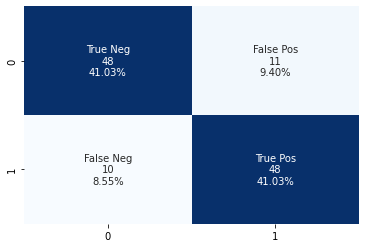

In [22]:
knn = KNeighborsClassifier(n_neighbors=4, algorithm='kd_tree',weights= 'distance')
knn.fit(x_train.values,y_train)
#Testes
y_predicted_knn = knn.predict(x_test.values)

accuracy_mlp = accuracy_score(y_test, y_predicted_knn)
print(f"Accuracy : {accuracy_mlp*100:.2f}%")
print(f'Recall: {recall_score(y_test, y_predicted_knn)*100:.2f}%')
print(f'Precision: {precision_score(y_test, y_predicted_knn)*100:.2f}%')
print(f'f1-score: {f1_score(y_test, y_predicted_knn)*100:.2f}%')

# Cálculo da matriz de confusão
cm = confusion_matrix(y_test, y_predicted_knn, labels=knn.classes_)

group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in cm.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in cm.flatten()/np.sum(cm)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

sns.heatmap(cm, annot=labels, fmt='', cmap='Blues', cbar=False)

### SVM Classifier

Accuracy : 82.05%
Recall: 82.76%
Precision: 81.36%
f1-score: 82.05%


<AxesSubplot:>

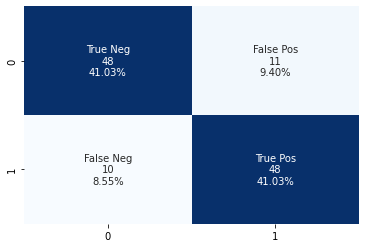

In [23]:
svm_model = svm.SVC(random_state=1, gamma='scale', kernel='rbf')
#treino
svm_model.fit(x_train, y_train)
y_predicted_svm = svm_model.predict(x_test)

accuracy_svm = accuracy_score(y_test, y_predicted_svm)

print(f"Accuracy : {accuracy_svm*100:.2f}%")
print(f'Recall: {recall_score(y_test, y_predicted_svm)*100:.2f}%')
print(f'Precision: {precision_score(y_test, y_predicted_svm)*100:.2f}%')
print(f'f1-score: {f1_score(y_test, y_predicted_svm)*100:.2f}%')

# Cálculo da matriz de confusão
cm = confusion_matrix(y_test, y_predicted_svm, labels=knn.classes_)

group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in cm.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in cm.flatten()/np.sum(cm)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

sns.heatmap(cm, annot=labels, fmt='', cmap='Blues', cbar=False)

Finalmente, é possível perceber que o algoritmo Random Forest obteve o melhor desempenho em relação aos demais algoritmos testados. 